# Analysis: Creating an Algorithm to Bypass ComboCompare Automation

In this notebook, I present a comprehensive analysis of my attempt to create a machine learning algorithm that will bypass certain parts of the ComboCompare automation.

## Section 1: Project Background

### 1.1: Description

> LTC Tree is a nation-wide network of agents who work with all the major Traditional and Hybrid Long Term Care Insurance companies.  We help our clients shop the entire market to find the best company at the best price.  Therefore, our **efficient virtual process** is 180 degrees from what you would expect from a local agent. With LTC Tree, we will FedEx you all of the top company’s information direct to you. Your information will include side-by-side cost comparisons of the top ten companies.  Most importantly, you can then review it comfortably at your home on your own time. (Source: [Company Website](https://www.ltctree.com/))

**Goal:** To consider whether the use of a machine learning algorithm will make a substantial contribution to the goal of providing customers with an **efficient virtual process**.

### 1.2: Deterrents

**Data collection:** This project would require a preprocessed dataset that's suitable for analysis and model training. At the present, it's not clear what all data is needed and where it's located, though this should be possible to determine with a bit of collaborative discussion.

**Big data:** For this report, I've trained a model on a very small subset of the full dataset (just over 2%). This could lead to wildly varying assessments over the viability of this project. In general, the more data that's available, the more flexibility we'll have with training a model. Unfortunately, big data introduces many other concerns, such as data storage, memory allocation, and performance optimization.

**Categorical data:** During my preliminary analysis of the dataset, I noticed that most of the observations contained data that would fit into one or more categories. Machine learning algorithms are notorious for preferring numerical values, so much time would need to be spent on encoding these variables properly. Doing so could lead to the [curse of dimensionality], or overfitting on the training set. Ironically, this issue might be mitigated by the previous concern (the use of big data).

**Dependencies:** The current algorithm was developed from a database that is dependent on the use of ComboCompare. From my understanding, that desktop application is under active development and is frequently updated. Any model trained on data from that application will need to be retrained and maintained to ensure it stays in lock step with results that could be gleaned from ComboCompare. This means that, while a bypass of the desktop application may be possible when running quotes, it will still need to be referenced every so often to ensure the model remains accurate and applicable to the process at hand.

To summarize, a project of this scale could be quite the undertaking, but it's not impossible. The next best step would be to talk through these hurdles and decide if this project would be beneficial to the desired goal.

## Section 2: Data

*Manipulation and analysis.*

### 2.1: Collection

The data was retrieved from a PostgreSQL database containing ComboCompare results. The first dataset used in this analysis was from the test table `combo_compare_results` in `public_test`. This dataset contained only around 200 observations. The second dataset was pulled from the official `combo_compare_results` table under `public`, where I simply took the first one thousand rows shown in the SQL database. However, this section of the dataset was biased towards certain responses and was not a representative sample of the full dataset. 

To mitigate this, I took a third sample of the dataset by selecting the first and last twelve thousand rows and concatenating them into one dataset. Again, the observations are heavily skewed towards certain attribute values, but there is a bit more variation in the data. Ideally, the full dataset itself would be used to build a model.

To start, we'll import the required libraries:

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)

training_data1 = pd.read_csv("cc_test_12k_start.csv")
training_data2 = pd.read_csv("cc_test_12k_lincoln.csv")
test_data1 = pd.read_csv("cc_test.csv")
test_data2 = pd.read_csv("cc_test_1k.csv")

Next, we'll create the training dataset, which is a concatenation of the first and last twelve thousand rows from `combo_compare_results`:

In [2]:
df = training_data1.append(training_data2)
df.head()

,id,fkey_reference_id,company,state,gender,age,marital,premium,benefit,inflation,schedule,total_ltc,face_amount,monthly_ltc,total_ltc_80,monthly_ltc_80,timestamp,monthly_ltc_85,total_ltc_85
0,1769744,3215,Securian Financial SecureCare UL,SD,Female,47,Married,140000,6 Years,3% Compound,Single Pay,618357,191193,7966,1640091,21129,1/10/2020 6:50:00 AM,24495,1901357
1,1769745,3215,Securian Financial SecureCare UL,SD,Female,48,Married,140000,6 Years,3% Compound,Single Pay,627106,193898,8079,1614850,20804,1/10/2020 6:50:14 AM,24118,1872096
2,1769746,3215,Securian Financial SecureCare UL,SD,Female,55,Married,140000,6 Years,3% Compound,Single Pay,586555,181360,7557,1228117,15822,1/10/2020 6:51:51 AM,18342,1423756
3,1769747,3215,Securian Financial SecureCare UL,SD,Female,56,Married,140000,6 Years,3% Compound,Single Pay,574476,177625,7401,1167791,15045,1/10/2020 6:52:05 AM,17442,1353820
4,1769748,3215,Securian Financial SecureCare UL,SD,Female,57,Married,140000,6 Years,3% Compound,Single Pay,562396,173890,7245,1109937,14299,1/10/2020 6:52:18 AM,16577,1286750


### Step 2.2: Distill.

Before moving on to exploratory data analysis, I need to make sure that the dataset is tidy and only contains the necessary relevant information.

In [3]:
df.shape

(24000, 19)

In [4]:
df.columns

Index(['id', 'fkey_reference_id', 'company', 'state', 'gender', 'age',
       'marital', 'premium', 'benefit', 'inflation', 'schedule', 'total_ltc',
       'face_amount', 'monthly_ltc', 'total_ltc_80', 'monthly_ltc_80',
       'timestamp', 'monthly_ltc_85', 'total_ltc_85'],
      dtype='object')

We've confirmed that there are twenty-four thousand rows, and there are 19 features. From my understanding, each row represents a hypothetical individual insurance quote. Two of the columns identify these individuals. Of the remaining 17, there are features, multiple responses, and timestamps for when the data was collected.

We don't want the columns that are going to identify observations, because our dataset already has an index. These should be dropped from the dataset.

> **Note:** There's a chance that `fkey_reference_id` points to necessary data that exists in another table. If this is the case, then the goal should be to combine all related data into one table and continue to drop references to other datasets.

Let's continue to examine the dataset:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 11999
Data columns (total 19 columns):
id                   24000 non-null int64
fkey_reference_id    24000 non-null int64
company              24000 non-null object
state                24000 non-null object
gender               24000 non-null object
age                  24000 non-null int64
marital              24000 non-null object
premium              24000 non-null int64
benefit              24000 non-null object
inflation            24000 non-null object
schedule             24000 non-null object
total_ltc            24000 non-null int64
face_amount          24000 non-null int64
monthly_ltc          24000 non-null int64
total_ltc_80         24000 non-null int64
monthly_ltc_80       24000 non-null int64
timestamp            24000 non-null object
monthly_ltc_85       24000 non-null int64
total_ltc_85         24000 non-null int64
dtypes: int64(11), object(8)
memory usage: 3.7+ MB


I'm pleased to see that there are no missing values in this dataset. Features are typed as either `object` or `int64`. We can save on memory if we cast the `object` columns to a different type.

Speaking of type, let's examine the numerical features.

In [6]:
df.describe()

,id,fkey_reference_id,age,premium,total_ltc,face_amount,monthly_ltc,total_ltc_80,monthly_ltc_80,monthly_ltc_85,total_ltc_85
count,2.400000e+04,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,2.400000e+04
mean,1.944691e+06,2327.007833,55.475833,89602.916667,3.353945e+05,111912.792625,4487.616542,5.983376e+05,8004.282708,8934.595375,6.763643e+05
std,3.040723e+05,705.493072,9.546804,27464.120589,1.681379e+05,55490.452586,2358.464736,3.248423e+05,4324.925000,4934.274704,3.794742e+05
min,1.429243e+06,1701.000000,40.000000,50000.000000,1.375270e+05,50006.000000,1923.000000,1.515060e+05,2104.000000,2104.000000,1.515060e+05
25%,1.785510e+06,1723.000000,47.000000,70000.000000,2.195300e+05,73541.750000,2879.000000,3.528670e+05,4734.000000,5226.000000,3.922280e+05
50%,2.012441e+06,1868.500000,55.000000,90000.000000,2.903400e+05,97622.000000,3821.000000,5.167030e+05,6937.000000,7678.000000,5.779680e+05
75%,2.223679e+06,3133.000000,63.000000,100000.000000,3.972430e+05,132284.000000,5290.000000,7.640405e+05,10238.500000,11402.000000,8.623310e+05
max,2.229679e+06,3572.000000,75.000000,150000.000000,1.405964e+06,468655.000000,19527.000000,2.801231e+06,36089.000000,41838.000000,3.247467e+06


`age` and `premium` are described as numeric; however, through previous analysis I've determined that `premium` is actually a categorical variable that can only take on one of a few different types.

In [7]:
df['premium'].unique()

array([140000, 150000,  70000,  90000, 100000,  80000, 120000,  60000,
       110000,  50000, 130000])

The only possibilities for `premium` are these discrete categories, so it's not numeric at all.

Let's take a closer look at the other categorical variables.

In [8]:
categories = ['company', 'state', 'gender', 'marital', 'premium', 'benefit', 'inflation', 'schedule', 'age']
for item in categories:
    unique = df[item].unique()
    print(f'Column "{item}" has {len(unique)} entries: {unique}')

Column "company" has 4 entries: ['Securian Financial SecureCare UL' 'Nationwide CareMatters II'
 'Pacific Life PremierCare Choice 2019' 'Lincoln MoneyGuard III']
Column "state" has 12 entries: ['SD' 'NJ' 'TN' 'PA' 'TX' 'WY' 'WV' 'WI' 'WA' 'VT' 'VA' 'UT']
Column "gender" has 2 entries: ['Female' 'Male']
Column "marital" has 2 entries: ['Married' 'None']
Column "premium" has 11 entries: [140000 150000  70000  90000 100000  80000 120000  60000 110000  50000
 130000]
Column "benefit" has 2 entries: ['6 Years' '5 Years']
Column "inflation" has 3 entries: ['3% Compound' 'None' '5% Compound (actually 5% Simple)']
Column "schedule" has 3 entries: ['Single Pay' '10 Years' '5 Years']
Column "age" has 36 entries: [47 48 55 56 57 58 59 60 61 63 64 65 46 40 41 42 43 44 45 66 50 53 54 62
 49 51 52 67 68 69 70 73 75 71 72 74]


Now, this is where my biggest concern lies. I know for a fact from previous analysis that the categories shown here are **not** all of the ones that are available in the full dataset. Any model trained on this dataset would necessarily perform poorly on the full dataset, because the **imbalanced datasets** do not take all the possibilities into account. Issues like these may or may not be of concern depending on **how we choose to encode these variables**. One-hot encoding, for instance, would lead to high-dimensionality and the absence of coefficients for values that don't exist in the training set.

There are a few solutions, some more easily done than others:

- One solution is to **take a better sample of the full dataset**. This would require logging into the DB server and exporting the desired rows, which could lengthen the time it takes to perform the analysis.
- Another is to **manually insert all known values**. This can be problematic, however, if a brand new value were to be added to one of these categories. Hard-coding is generally not the best solution.
- Finally, we could try to **mitigate for unknown values** by anticipating their absence and adding in checks to include them should they occur and update the model. (For example, we would merge the training and test sets before any transformation is performed to ensure all applicable factor levels are considered.)

Because I've seen some of the missing categories in the datasets that will be used to evaluate performance already, I'm choosing to **merge and combine** the columns for all datasets to ensure the proper categories are included.

In [9]:
from collections import defaultdict
unique_cols = defaultdict(list)

for item in categories:
    unique_cols[item] = set(df[item].unique().tolist() + 
                         test_data1[item].unique().tolist() + 
                         test_data2[item].unique().tolist())
print(unique_cols)

defaultdict(<class 'list'>, {'company': {'Lincoln MoneyGuard III', 'State Life Asset-Care 2019 Single Pay', 'Nationwide CareMatters II', 'Pacific Life PremierCare Choice 2019', 'Lincoln MoneyGuard II 2020', 'Securian Financial SecureCare UL'}, 'state': {'WI', 'SC', 'VT', 'IN', 'MN', 'MT', 'CA', 'AR', 'DE', 'MA', 'VA', 'NY', 'ND', 'KY', 'AL', 'ME', 'MD', 'MO', 'OR', 'MS', 'IA', 'LA', 'HI', 'UT', 'OK', 'WA', 'KS', 'AK', 'TX', 'NV', 'WY', 'AZ', 'NH', 'OH', 'RI', 'DC', 'CT', 'TN', 'FL', 'GA', 'NE', 'SD', 'IL', 'MI', 'NM', 'ID', 'NJ', 'NC', 'CO', 'PA', 'WV'}, 'gender': {'Male', 'Female'}, 'marital': {'Married', 'None'}, 'premium': {80000, '50000', 90000, '80000', '100000', 100000, 110000, 120000, '$140,000', '$130,000', 50000, 130000, '60000', 140000, 60000, '90000', 150000, 70000, '$50,000'}, 'benefit': {'6 Years', '5 Years'}, 'inflation': {'5% Simple', 'None', '3% Compound', '5% Compound (actually 5% Simple)'}, 'schedule': {'Single Pay', '10 Years', '5 Years'}, 'age': {40, 41, 42, 43, 44,

In [10]:
len(df['age'].unique().tolist())

36

Now we've got a better idea of what all the possible values are for these categories. We can also see that there's quite a bit of mislabelled data, especially in the `premium` and `inflation` columns, which have repetitive data with different labels. We'll need to be sure to clean these up.

For now, I've decided to perform the following preprocessing steps:

- Drop duplicate observations
- Drop the columns `id` and `fkey_reference_id`
- Clean up the variations in `premium` and `inflation`

These steps will be performed on all datasets for consistency. In addition, I'll be creating a copy of the training dataset with encoded values to assist with further exploration.

In [11]:
# Clean up training data
df = df.drop_duplicates()
df = df.drop(columns=['id', 'fkey_reference_id', 'timestamp'], errors='ignore')
df.loc[df['premium']=='$50,000', 'premium'] = '50000'
df.loc[df['premium']=='$130,000', 'premium'] = '130000'
df.loc[df['premium']=='$140,000', 'premium'] = '140000'
df.loc[df['inflation']=='5% Compound (actually 5% Simple)', 'inflation'] = '5% Simple'
df = df.astype({'premium': 'int64'})

In [12]:
# Repeat for test_data1
test_data1 = test_data1.drop_duplicates()
test_data1 = test_data1.drop(columns=['id', 'fkey_reference_id', 'timestamp'], errors='ignore')
test_data1.loc[test_data1['premium']=='$50,000', 'premium'] = '50000'
test_data1.loc[test_data1['premium']=='$130,000', 'premium'] = '130000'
test_data1.loc[test_data1['premium']=='$140,000', 'premium'] = '140000'
test_data1.loc[test_data1['inflation']=='5% Compound (actually 5% Simple)', 'inflation'] = '5% Simple'
test_data1 = test_data1.astype({'premium': 'int64'})

In [13]:
# Repeat for test_data2
test_data2 = test_data2.drop_duplicates()
test_data2 = test_data2.drop(columns=['id', 'fkey_reference_id', 'timestamp'], errors='ignore')
test_data2.loc[test_data2['premium']=='$50,000', 'premium'] = '50000'
test_data2.loc[test_data2['premium']=='$130,000', 'premium'] = '130000'
test_data2.loc[test_data2['premium']=='$140,000', 'premium'] = '140000'
test_data2.loc[test_data2['inflation']=='5% Compound (actually 5% Simple)', 'inflation'] = '5% Simple'
test_data2 = test_data2.astype({'premium': 'int64'})

In [14]:
# Confirm that all variations have been cleaned up
from collections import defaultdict
unique_cols = defaultdict(list)

for item in categories:
    unique_cols[item] = set(df[item].unique().tolist() + 
                         test_data1[item].unique().tolist() + 
                         test_data2[item].unique().tolist())
print(unique_cols)

defaultdict(<class 'list'>, {'company': {'Lincoln MoneyGuard III', 'State Life Asset-Care 2019 Single Pay', 'Nationwide CareMatters II', 'Pacific Life PremierCare Choice 2019', 'Lincoln MoneyGuard II 2020', 'Securian Financial SecureCare UL'}, 'state': {'WI', 'SC', 'VT', 'IN', 'MN', 'MT', 'CA', 'AR', 'DE', 'MA', 'VA', 'NY', 'ND', 'KY', 'AL', 'ME', 'MD', 'MO', 'OR', 'MS', 'IA', 'LA', 'HI', 'UT', 'OK', 'WA', 'KS', 'AK', 'TX', 'NV', 'WY', 'AZ', 'NH', 'OH', 'RI', 'DC', 'CT', 'TN', 'FL', 'GA', 'NE', 'SD', 'IL', 'MI', 'NM', 'ID', 'NJ', 'NC', 'CO', 'PA', 'WV'}, 'gender': {'Male', 'Female'}, 'marital': {'Married', 'None'}, 'premium': {140000, 100000, 80000, 120000, 60000, 150000, 70000, 90000, 110000, 50000, 130000}, 'benefit': {'6 Years', '5 Years'}, 'inflation': {'5% Simple', 'None', '3% Compound'}, 'schedule': {'Single Pay', '10 Years', '5 Years'}, 'age': {40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 

As a final preprocessing step, I'll be making a second encoded dataset to inform my exploratory analysis. This won't be used for modelling, as the encoding used here could lead to unfair weights for some features, depending on the machine learning algorithm chosen. It's simply to ensure that I have numeric data to work with for spotting correlations and other statistical observations.

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

encoded_df = df.copy()

for item in categories[:-1]:
    encoded_df[item] = le.fit_transform(df[item])

encoded_df.head()

,company,state,gender,age,marital,premium,benefit,inflation,schedule,total_ltc,face_amount,monthly_ltc,total_ltc_80,monthly_ltc_80,monthly_ltc_85,total_ltc_85
0,3,2,0,47,0,9,1,0,2,618357,191193,7966,1640091,21129,24495,1901357
1,3,2,0,48,0,9,1,0,2,627106,193898,8079,1614850,20804,24118,1872096
2,3,2,0,55,0,9,1,0,2,586555,181360,7557,1228117,15822,18342,1423756
3,3,2,0,56,0,9,1,0,2,574476,177625,7401,1167791,15045,17442,1353820
4,3,2,0,57,0,9,1,0,2,562396,173890,7245,1109937,14299,16577,1286750


I've left `age` as it is, since it's already represented numerically.

Now, we've finished cleaning up the training and test datasets, and we've created a numerical dataset to use for statistical analysis.

### Step 2.3: Discover.

In this section, I'll perform **exploratory data analysis** to get a better understanding of the data and how it will be used to create a machine learning algorithm.

To start, let's take another look at the dataset:

In [16]:
df.tail()

,company,state,gender,age,marital,premium,benefit,inflation,schedule,total_ltc,face_amount,monthly_ltc,total_ltc_80,monthly_ltc_80,monthly_ltc_85,total_ltc_85
11995,Lincoln MoneyGuard III,TN,Female,44,Married,60000,6 Years,3% Compound,10 Years,199312,66762,2568,577661,7442,8628,669682
11996,Lincoln MoneyGuard III,TN,Female,43,Married,60000,6 Years,3% Compound,10 Years,202834,67941,2613,605504,7801,9044,701961
11997,Lincoln MoneyGuard III,TN,Female,42,Married,60000,6 Years,3% Compound,10 Years,206477,69162,2660,634873,8179,9482,736008
11998,Lincoln MoneyGuard III,TN,Female,41,Married,60000,6 Years,3% Compound,10 Years,208983,70001,2692,661855,8527,9885,767289
11999,Lincoln MoneyGuard III,TN,Female,40,Married,60000,6 Years,3% Compound,10 Years,211549,70861,2725,690080,8890,10306,800010


In [17]:
df.shape

(24000, 16)

We still have 24,000 observations, but now only 16 columns. We still have not chosen our response column. Let's take a closer look at all our columns so we can move forward. We can use `encoded_df` to view a histogram of all the columns in the dataset.

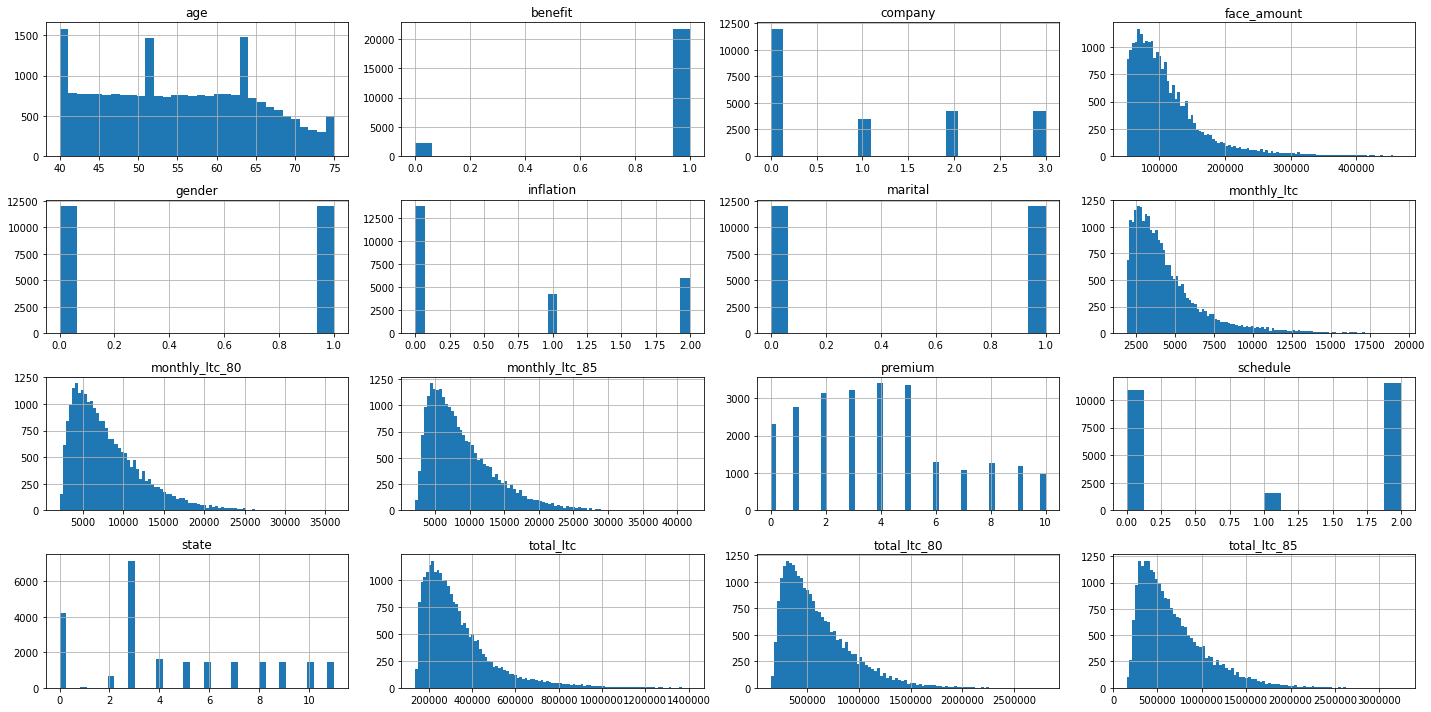

In [18]:
encoded_df.hist(figsize=(20,10), layout=(4,4), bins='auto')
plt.tight_layout()
plt.show()

We can confirm that the dataset contains mostly categorical variables, and that `premium` is indeed categorical and not numeric. We can also see that `face_amount`, `monthly_ltc`, `monthly_ltc_80`, `monthly_ltc_85`, `total_ltc`, `total_ltc_80` and `total_ltc_85` all show remarkably similar distributions. This suggests that these features may be highly correlated with each other and that one of these could be the response. What's more, they're not normally distributed but are instead skewed to the right, which could have an impact on the final model, depending on the algorithm we employ. We may want to **employ some log transformation on the response** in order to bolster model performance.

Let's check to see if these columns are, indeed, correlated.

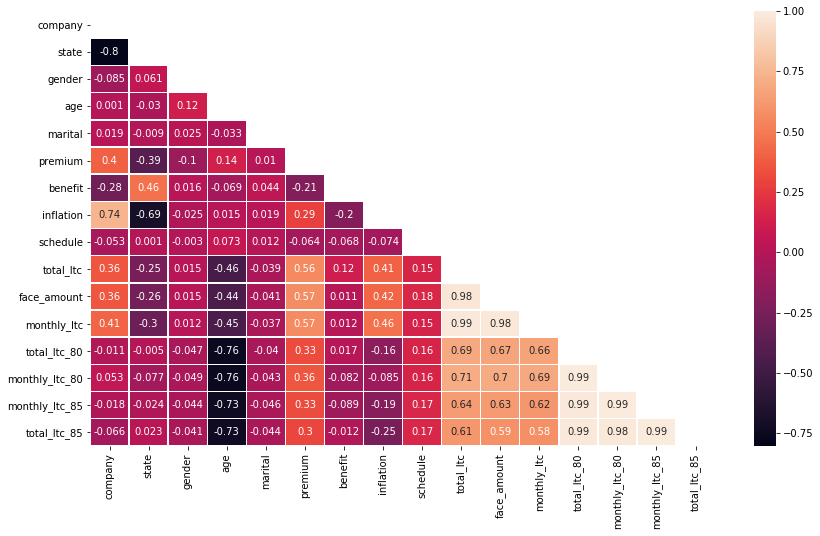

In [19]:
plt.figure(figsize=(14,8))
mask = np.triu(np.ones_like(encoded_df.corr(), dtype=bool))
sns.heatmap(round(encoded_df.corr(method='spearman'), 3), mask=mask, annot=True, linewidths=0.5)
plt.show()

It appears that those columns are, indeed, highly correlated with one another. We definitely want to remove these from the dataset. From what I know of the company (and what we can see on the graph) it appears that `total_ltc` alone would be more than sufficient as a response variable. The other features are probably variations on this that are used when generating insurance quotes.

For this dataset, I'm not concerned about outliers, as they tend [not to apply to categorical data](https://medium.com/owl-analytics/categorical-outliers-dont-exist-8f4e82070cb2). We've also confirmed that there are no missing values up until this point; however, due to the nature of the **imbalanced dataset** we have at this time, the final processed training set *will* indeed have several missing values. It may be necessary to use a sparse matrix, dimensionality reduction, or another solution to deal with this.

So far, the data are right in line with what the desktop application produces. Each row represents one unique combination, and so our visuals come to look like explicit observations on the graph, with very little overlap. For instance:

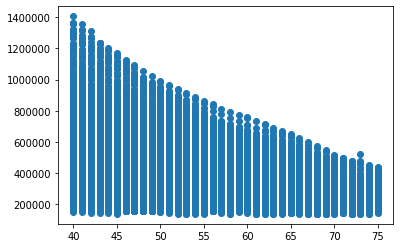

In [20]:
plt.scatter(df['age'], df['total_ltc'])

Other scatter plots show similar results, with explicit dots to denote each combination (or observation) and very little overlap.

### Step 2.4: Dissect.

In the previous section, I've identified the following necessary transformations for both the training and test sets:

1. Removal of correlated response columns
2. Log transformation of the response
3. Include all possible predictors and get dummies
4. Check for null values and perform dimensionality reduction

Let's take them one at a time.

#### 1. Removal of correlated response columns

We'll drop all other possible response columns from the datasets.

In [21]:
cols_to_drop = ['face_amount', 'monthly_ltc', 'total_ltc_80', 'total_ltc_85', 'monthly_ltc_80', 'monthly_ltc_85']

df = df.drop(columns=cols_to_drop, errors='ignore')
encoded_df = encoded_df.drop(columns=cols_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=cols_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=cols_to_drop, errors='ignore')

We can check to see that correlation has improved:

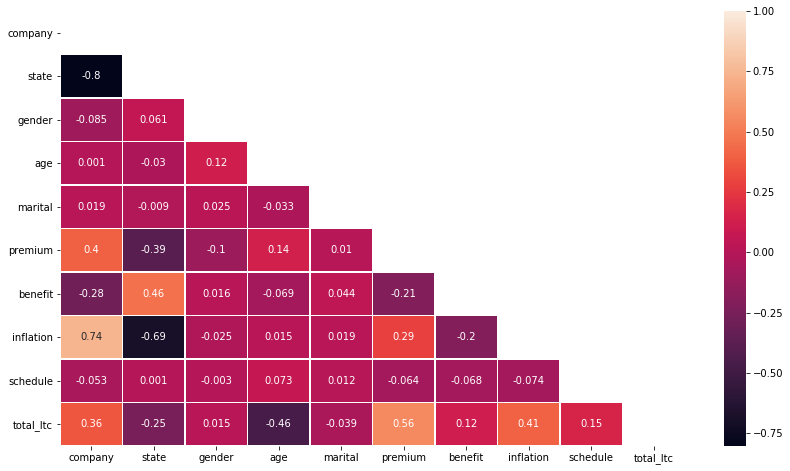

In [22]:
plt.figure(figsize=(14,8))
mask = np.triu(np.ones_like(encoded_df.corr(), dtype=bool))
sns.heatmap(round(encoded_df.corr(method='spearman'), 3), mask=mask, annot=True, linewidths=0.5)
plt.show()

#### 2. Get dummies

Next, I'll create a dummy dataframe for modeling.

In [23]:
dummy_df = df.copy()
dummy_df = pd.get_dummies(dummy_df, columns=categories)

In [24]:
dummy_df.shape

(24000, 76)

I chose to `.get_dummies()` on all the columns, including `age` and `premium`, because those are also categories in the context of this problem. However, I'd like to compare the automated solution as well, so I'll also create a dummy dataframe that retains `age` and `premium` as integer columns.

In [25]:
auto_dummy_df = df.copy()
auto_dummy_df = pd.get_dummies(auto_dummy_df)

In [26]:
auto_dummy_df.shape

(24000, 31)

- Perform any necessary transformations before building models.
  - encoding, imputation
  - dimensionality reduction
- Explain why certain transformations were not done.
- Explain if the data set needs no transformation.

6. Is there any missing data?
  - check for NULL values
  - use the [missingno](https://github.com/ResidentMario/missingno) package to visualize
  - do you need to remove these observations?
  - can you impute the missing data? should you?
  - what affect will this have on your model(s)?


  - what can you see with this data? what CAN'T you see?
  - can this data help you achieve the objectives outlined in Part 1?



### Step 2.5: Divide.

Split the data for modeling.

- Split the data into train/validation/test sets.

In [27]:
dummy_df.head()

,total_ltc,company_Lincoln MoneyGuard III,company_Nationwide CareMatters II,company_Pacific Life PremierCare Choice 2019,company_Securian Financial SecureCare UL,state_NJ,state_PA,state_SD,state_TN,state_TX,...,age_66,age_67,age_68,age_69,age_70,age_71,age_72,age_73,age_74,age_75
0,618357,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,627106,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,586555,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,574476,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,562396,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Stage 3: Develop

*Modeling and prediction.*

### Step 3.1: Deliberate.

Train on a few different models.

- Identify candidate models.
  - what kind of model(s) do you need to achieve the Part 1 goal?
  - what kind of model(s) work best with the data you have on hand?
  - will you build your own models or use available ones?
  - how will you measure the quality of your chosen model(s)?

* df with all dummy predictors
* df with available dummy predictors
* encoded_df with factorized predictors

- Build preliminary models on the training set.
- Store preliminary measures of model quality.
  - use a cross-model validation measure, if possible

In [28]:
# dummy_df: 76 features
init_frame = dummy_df.copy()

X1 = init_frame.drop('total_ltc', 1)
y1 = init_frame['total_ltc']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=0)

dummy_regressor = LinearRegression()
dummy_regressor.fit(X1_train, y1_train)

y1_hat = dummy_regressor.predict(X1_test)

r2 = metrics.r2_score(y1_test, y1_hat)
adj_r2 = (1 - (1 - r2) * ((X1_test.shape[0] - 1) / 
          (X1_test.shape[0] - X1_test.shape[1] - 1)))
r2, adj_r2

(0.8740980350940095, 0.8727725652220346)

In [29]:
# auto_dummy_df: 31 features
init_frame = auto_dummy_df.copy()

X2 = init_frame.drop('total_ltc', 1)
y2 = init_frame['total_ltc']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=0)

auto_dummy_regressor = LinearRegression()
auto_dummy_regressor.fit(X2_train, y2_train)

y2_hat = auto_dummy_regressor.predict(X2_test)

r2 = metrics.r2_score(y2_test, y2_hat)
adj_r2 = (1 - (1 - r2) * ((X2_test.shape[0] - 1) / 
          (X2_test.shape[0] - X2_test.shape[1] - 1)))
r2, adj_r2

(0.8714487578559891, 0.8709108115225646)

In [30]:
# encoded_df: 10 features
init_frame = encoded_df.copy()

X3 = init_frame.drop('total_ltc', 1)
y3 = init_frame['total_ltc']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.30, random_state=0)

encoded_regressor = LinearRegression()
encoded_regressor.fit(X3_train, y3_train)

y3_hat = encoded_regressor.predict(X3_test)

r2 = metrics.r2_score(y3_test, y3_hat)
adj_r2 = (1 - (1 - r2) * ((X3_test.shape[0] - 1) / 
          (X3_test.shape[0] - X3_test.shape[1] - 1)))
r2, adj_r2

(0.8388371103713622, 0.8386353765734961)

### Step 3.2: Decide.

Validate to choose the best model.

- Identify final model(s).
  - how did the model(s) perform on the training set?
- Check preliminary models on the validation set.
- Store intermediary measures of model quality.
  - may need to use cross-validation on multiple models

In [31]:
# Run dummy_regressor on 1k dataset
unseen_init_frame = test_data2.copy()
unseen_init_frame = pd.get_dummies(unseen_init_frame, columns=categories)

unseen_X1 = unseen_init_frame.drop('total_ltc', 1)
unseen_y1 = unseen_init_frame['total_ltc']

missing_cols = set( X1_train.columns ) - set( unseen_X1.columns )
for c in missing_cols:
    unseen_X1[c] = 0
unseen_X1 = unseen_X1[X1_train.columns]

y1_pred = dummy_regressor.predict(unseen_X1)
r2 = metrics.r2_score(unseen_y1, y1_pred)
adj_r2 = (1 - (1 - r2) * ((unseen_X1.shape[0] - 1) / 
          (unseen_X1.shape[0] - unseen_X1.shape[1] - 1)))
r2, adj_r2

(0.7693530306578369, 0.7506316857437003)

In [32]:
# Run auto_dummy_regressor on 1k dataset
unseen_init_frame = test_data2.copy()
unseen_init_frame = pd.get_dummies(dummy_df)

unseen_X2 = unseen_init_frame.drop('total_ltc', 1)
unseen_y2 = unseen_init_frame['total_ltc']

missing_cols = set( X2_train.columns ) - set( unseen_X2.columns )
for c in missing_cols:
    unseen_X2[c] = 0
unseen_X2 = unseen_X2[X2_train.columns]

y2_pred = auto_dummy_regressor.predict(unseen_X2)
r2 = metrics.r2_score(unseen_y2, y2_pred)
adj_r2 = (1 - (1 - r2) * ((unseen_X2.shape[0] - 1) / 
          (unseen_X2.shape[0] - unseen_X2.shape[1] - 1)))
r2, adj_r2

(-0.5665820384841203, -0.5685427986808129)

In [33]:
# Run encoded_regressor on 1k dataset
unseen_init_frame = test_data2.copy()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for item in categories:
    unseen_init_frame[item] = le.fit_transform(test_data2[item])

unseen_X3 = unseen_init_frame.drop('total_ltc', 1)
unseen_y3 = unseen_init_frame['total_ltc']

missing_cols = set( X3_train.columns ) - set( unseen_X3.columns )
for c in missing_cols:
    unseen_X3[c] = 0
unseen_X3 = unseen_X3[X3_train.columns]

y3_pred = encoded_regressor.predict(unseen_X3)
r2 = metrics.r2_score(unseen_y3, y3_pred)
adj_r2 = (1 - (1 - r2) * ((unseen_X3.shape[0] - 1) / 
          (unseen_X3.shape[0] - unseen_X3.shape[1] - 1)))
r2, adj_r2

(-3.0627862220848305, -3.099720642285601)


### Step 3.3: Declare.

Test to evaluate model performance.

- Test chosen model(s).
  - how well does the model perform on unseen data?
- Check chosen models on the test set.
- Store final measures of model quality.

# Stage 4: Deploy

*Production and distribution.*

### Step 4.1: Demonstrate.

Demonstrate model performance.

- Make predictions on unseen data.

### Step 4.2: Distribute.

Deploy model to production.

- Make model available to other users.

## Stage 5: Discuss

*Recap and reflection.*

### Step 5.1: Determine.

Review the final model.

- What conclusion(s) did you reach?
- How did your results align with or differ from your expectations?

### Step 5.2: Discourage.

Discuss challenges and obstacles.

- Did you run into any major issues?
imbalanced datasets; factors present in training but not test, and vice versa. many solutions, one would be to merge the datasets to get all possible factors and then separate them back out. after testing, the model would update itself based on the newly available factors. the goal is that over time all possible factors will have been taken into account and the model performance will significantly improve.
- Did you run into any minor issues?
- Were there any bugs to work through?
- Was there anything you just couldn't solve this go round?

### Step 5.3: Direct.

Opportunities for future research.

- What could you do differently next time?
take a truly representative sample of the dataset; having over 1000 rows with only one value for a significant feature will lead to extremely poor model performance if that feature is nonexistent in the test set. it's extremely important to make sure the training, validation and test sets match up as far as features go. in addition, it's necessary for those datasets to be representative of the actual data, or else the model will be irrelevant to actual use.
use a log-transformed response; the response was highly skewed to the right, which means the abnormal distribution could have negatively affected the linear regression. more analysis is needed to see whether a log transformation would help improve accuracy in predictions.
- How could you extend this project?
- What would you like to try next?

### Step 5.4: Disseminate.

Resources for more information.

- How can we access resources used in this analysis?
- Where can readers find more information?
  - "The following resources were of immense help to me as I completed this project:"